# Automatic Channel Masking

The goal of this method is to apply a mask on insignificant channels with no signal or negligible spikes.

### Baseline version

The baseline version works by filtering out channels with mean spike rates that are below the *no_spike_threshold* parameter. The spike rate is computed using *firing_rates* in the *statistics* module. 

This method is basic and only effective in masking out channels with almost no spikes. Below are some artificial spiketrains that demonstrate this method:

(<AxesSubplot:xlabel='Time (s)'>, <Axes:ylabel='count'>, <Axes:>)

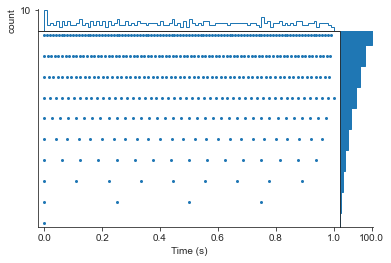

In [81]:
from neo.core import SpikeTrain
from quantities import s
import numpy as np
from viziphant.rasterplot import rasterplot_rates
import statistics

spiketrains = []
for i in range(1,11):
    times = np.arange(start=0, stop=1, step=1/(i**2))
    spiketrains.append(SpikeTrain(times*s, t_start=0.0, t_stop=1.0))
rasterplot_rates(spiketrains)

Here, 10 channels with quadratically increasing spike rates are created. The time duration is 1 second. Channel 1 has spike rate of 1 spike/sec, channel 2 is 4 spikes/sec.

Below is the baseline auto masking method. Because it is much simpler to create synthetic spiketrains than creating Data objects, this is a simplified version of the baseline method but functions identically. We use the default value 1 for no_spike_threshold. This value can be altered to test this methdod:

Channels masked:  [0]


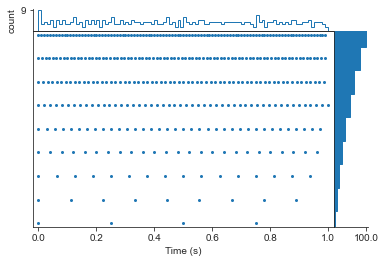

In [82]:
from miv.statistics import firing_rates
no_spike_threshold =  1    # Modify this value to test this method
mask_list = []
masked_spiketrains = []

spike_stats = firing_rates(spiketrains)
for channel in range(len(spike_stats['rates'])):
    if spike_stats['rates'][channel] <= no_spike_threshold:
        mask_list.append(channel)
    else:
        masked_spiketrains.append(spiketrains[channel])

print("Channels masked: ", np.array(mask_list))
try:
    rasterplot_rates(masked_spiketrains)
except IndexError:
    print("All channels masked")

This method is extremely primitive. 
-   The threshold parameter requires manual adjustment for the best result. 
-   Noise is not taken into consideration. This method would falsely mask out channels that contain only spikes and no noise since the number of noise spikes is usually higher. Vice versa, channels with lots of noise spikes and few neuron spikes will be kept.

In reality, spikes often occur at the same time among the channels. The difference across the channels is not just the number of spikes. Below is an attempt to recreate some artificial spikes:

-   Half of the channels contains only noise, the other half contains spikes and noise. 
-   When a layer of noise is applied to each channel, the layer is generated with a random array that marks the time for each individual noise spike. The number of noise spikes is also determined randomly.
-   The real spikes often show up not just as one single spike but a group of spikes within a short duration. It is not sure how long is the duration, so we simply repeat the spike at the same time.

In [147]:
# This function adds noise to a channel and returns the noisy channel
def add_noise(channel, noise_amount : float = 100, exp_duration : float = 1):
    noise_array = exp_duration*np.random.rand(int(noise_amount))    # an array with timestamps of noise spikes
    return np.concatenate((channel, noise_array))

The parameters can be tweaked to make these look more accurate.

(<AxesSubplot:xlabel='Time (s)'>, <Axes:ylabel='count'>, <Axes:>)

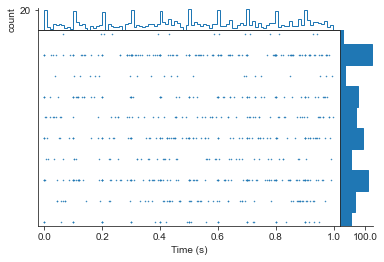

In [155]:
# Parameters:
experiment_duration = 1 # Length of experiment time in seconds
spike_duration = 0.1    # Length of spikes in second
spikes_per_second = 10  # Number of spikes per second
num_channels = 10       # Number of channels
noise_multiplier = 100  # Multiplier for the amount of noise in each channel
spike_strength = 3      # Multiplier for the number of times the spike is repeated

noise_amounts = np.random.rand(num_channels)
spiketrains = []
for chan in range(num_channels):
    if (chan%2 == 0):   # Even channels (0-based) contain spikes
        spikes = np.repeat(np.arange(start=0, stop=experiment_duration, step=1/spikes_per_second), spike_strength)
    else:
        spikes = []
    spiketrains.append(SpikeTrain(add_noise(spikes, noise_multiplier*noise_amounts[chan], experiment_duration)*s, experiment_duration))

# This is the comparison noise spikes that we will feed into the "improved" function later
noise_spikes = add_noise([], noise_multiplier*0.5)
# noise_spikes = add_noise([], noise_multiplier*np.random.rand(1))

rasterplot_rates(spiketrains, markerargs={'marker':'.', 'markersize':1})

### "Improved" version

The baseline method has no way of identifying which channel to mask out. Here comes the "improved" method of automatic channel masking.

In this improved method, we pass a spontaneous recording Data object parameter as the noise reference. Additionally, the parameters include a Data object from the spontaneous recording, a filter object that will be applied on all recordings, and a spike detector object that is used to detect spikes.

A time-binned array of the number of spikes is created for each comparison between the spontaneous spikes and the experiment spikes. The dot products are take between the same channels for each comparison. This dot product value is then used to evaluate whether the channel should be masked.

In [156]:
bins_per_second = 80      # change this parameter to change bin size

def bin_spikes(spikes, bins_per_second, experiment_duration):
    bins_array = np.arange(start=0, stop=experiment_duration, step=1/bins_per_second)
    spikes_bin_indices = np.digitize(spikes, bins_array)
    spikes_in_each_bin = np.zeros(bins_per_second*experiment_duration+1)
    for bin_index in spikes_bin_indices:
        spikes_in_each_bin[bin_index] += 1
    return spikes_in_each_bin

# 1: bin the spontaneous recording spikes
spontaneous_binned = bin_spikes(noise_spikes, bins_per_second, experiment_duration)

# 2: bin the experiment recording spikes and calculate dot product
dot_products = []
for channel in spiketrains:
    channel_binned = bin_spikes(channel, bins_per_second, experiment_duration)
    dot_products.append(np.dot(channel_binned, spontaneous_binned))

# 3: compare dot products and mask channels
mask_list = []
masked_spiketrains = []
threshold = np.mean(dot_products) + statistics.stdev(dot_products)
for channel_index in range(len(dot_products)):
    if (dot_products[channel_index] > threshold):
        mask_list.append(channel_index)
    else:
        masked_spiketrains.append(spiketrains[channel_index])

Dot products:  [8.0, 32.0, 58.0, 22.0, 51.0, 40.0, 27.0, 15.0, 68.0, 12.0]
Channels masked:  [2 8]


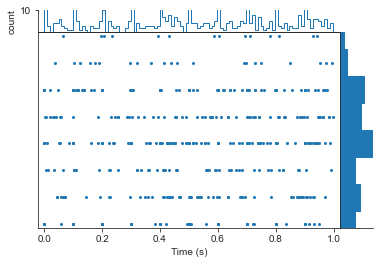

In [157]:
print("Dot products: ", dot_products)
print("Channels masked: ", np.array(mask_list))
try:
    rasterplot_rates(masked_spiketrains)
except IndexError:
    print("All channels masked")

After experimenting with tweaking parameters, we see that this method is extremely inconsistent. The channels that are being masked are often the channels that actually contain the spikes. Taking the dot products and comparing them doesn't seem like a viable solution as it only eliminates channels that look similar to that particular noise channel given for comparison.

Looking at spiketrains only provides information for the occurence of spikes. It may be better to instead look at each spike and identify the differences between a true neural spike and some other spike. 